# p53 Score Calculation
## Xiaonan Wang
## 21May2023

In [1]:
#%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
from os import listdir
from os.path import isfile, join
import re
import anndata
import seaborn as sns

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(name='gene_cmap', colors=['lightgrey', 'thistle', 'red', 'darkred']) 

sc.settings.set_figure_params(dpi=80, color_map='viridis', vector_friendly=False,  dpi_save=300)

scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.20.3 scipy==1.7.3 pandas==1.3.5 scikit-learn==1.0.1 statsmodels==0.13.1 python-igraph==0.9.8 louvain==0.7.1 pynndescent==0.5.5


In [2]:
adata = sc.read('./write/Ageing_processed.h5ad')

In [3]:
p53GL = np.genfromtxt('/home/xw251/rds/rds-bg200-hphi-gottgens/users/xw251/Lab_Members/Niki/Patel_SMQ2/Analysis_17Feb2021/p53GL.txt', dtype='str')

In [31]:
print(p53GL)

['Aen' 'Bax' 'Bbc3' 'Casp1' 'Ccng1' 'Cdkn1a' 'Ctsd' 'Eda2r' 'Ier5' 'Perp'
 'Phlda3' 'Pml' 'Pvt1' 'Sulf2' 'Tnfrsf10b' 'Zmat3']


In [4]:
adata_norm = anndata.AnnData(X=adata.raw.X, obs=adata.obs, var=adata.raw.var)

In [5]:
sc.pp.scale(adata_norm)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [6]:
sc.tl.score_genes(adata_norm,np.array(p53GL), score_name = 'p53S', use_raw=False)

computing score 'p53S'
    finished: added
    'p53S', score of gene set (adata.obs).
    698 total control genes are used. (0:00:01)


In [9]:
adata.obs['p53S'] = adata_norm.obs['p53S']

In [11]:
adata.write('./write/Ageing_processed.h5ad')

In [19]:
ct2change = {
    'MPP1': 'MPP',
    'MPP2': 'MPP',
    'MPP3': 'MPP'
}

In [21]:
adata.obs['newCT'] = [ct2change[x] if x in ct2change.keys() else x for x in adata.obs['Combined_CT']]

In [24]:
adata.obs['newCT'] = adata.obs['newCT'].astype('category')

In [25]:
adata.obs['newCT'].cat.categories

Index(['Basophil', 'Early erythoid', 'GMP', 'LMPP', 'LTHSC', 'Late erythoid',
       'Lymphoid', 'MEP', 'MPP', 'Megakaryocyte', 'Middle erythoid',
       'Neutrophil', 'STHSC'],
      dtype='object')

In [26]:
adata.obs['newCT'] = adata.obs['newCT'].cat.reorder_categories(['LTHSC', 'STHSC', 'MPP', 
                                                                'LMPP', 'GMP', 'MEP', 
                                                                'Early erythoid', 'Middle erythoid', 'Late erythoid', 
                                                                'Megakaryocyte', 'Basophil', 'Lymphoid', 'Neutrophil'])

In [27]:
pd.crosstab(adata.obs['Age'], adata.obs['newCT'])

newCT,LTHSC,STHSC,MPP,LMPP,GMP,MEP,Early erythoid,Middle erythoid,Late erythoid,Megakaryocyte,Basophil,Lymphoid,Neutrophil
Age,,,,,,,,,,,,,
16-week,223,433,935,466,71,305,640,507,668,236,146,260,1474
68-week,178,183,916,494,62,323,637,720,902,262,188,222,2200
88-week,741,303,718,451,76,299,337,680,1309,389,125,172,2457


LTHSC
68-week v.s. 88-week: Mann-Whitney-Wilcoxon test two-sided, P_val=5.405e-01 U_stat=6.790e+04
16-week v.s. 68-week: Mann-Whitney-Wilcoxon test two-sided, P_val=2.586e-03 U_stat=1.637e+04
16-week v.s. 88-week: Mann-Whitney-Wilcoxon test two-sided, P_val=8.225e-04 U_stat=7.043e+04
STHSC
68-week v.s. 88-week: Mann-Whitney-Wilcoxon test two-sided, P_val=6.185e-01 U_stat=2.847e+04
16-week v.s. 68-week: Mann-Whitney-Wilcoxon test two-sided, P_val=1.134e-01 U_stat=3.642e+04
16-week v.s. 88-week: Mann-Whitney-Wilcoxon test two-sided, P_val=2.553e-01 U_stat=6.237e+04
MPP
68-week v.s. 88-week: Mann-Whitney-Wilcoxon test two-sided, P_val=2.199e-02 U_stat=3.505e+05
16-week v.s. 68-week: Mann-Whitney-Wilcoxon test two-sided, P_val=4.067e-07 U_stat=3.700e+05
16-week v.s. 88-week: Mann-Whitney-Wilcoxon test two-sided, P_val=9.237e-03 U_stat=3.106e+05
LMPP
68-week v.s. 88-week: Mann-Whitney-Wilcoxon test two-sided, P_val=8.693e-01 U_stat=1.121e+05
16-week v.s. 68-week: Mann-Whitney-Wilcoxon test 

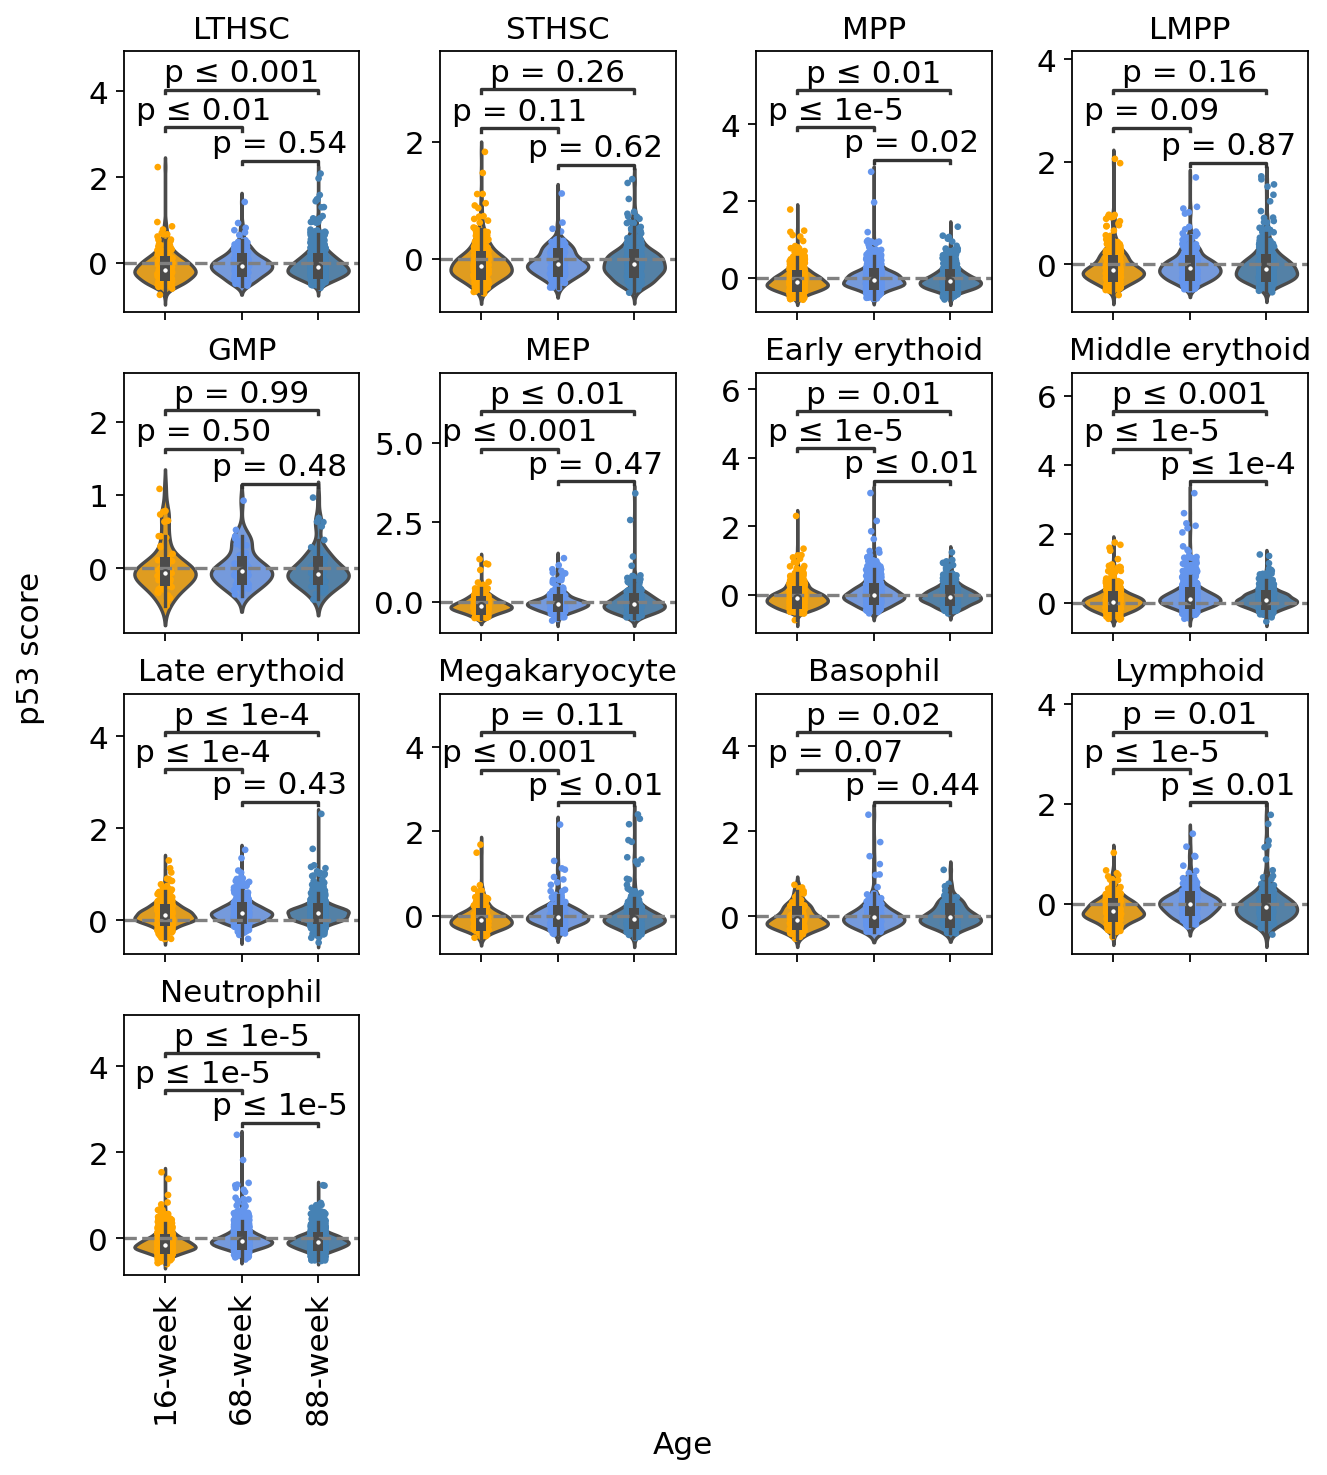

In [30]:
from statannot import add_stat_annotation
import seaborn as sns
cat = adata.obs['newCT'].cat.categories
fig, ax = plt.subplots(4,4, figsize=(8,9), squeeze=False, sharex=True)
for i in range(len(cat)):
    colidx = i%4
    rowidx = np.floor(i/4).astype(int)
    print(cat[i])
    idx = adata.obs['newCT'] == cat[i]
    df = adata[idx,:].obs[['p53S', 'Age']]
    bp = df['Age'].astype('category')
    bp = list(bp.cat.categories)
    bp = np.setdiff1d(bp, "WT")

    sns.violinplot(x='Age', y='p53S', scale='width', data=df,ax=ax[rowidx][colidx], palette=['orange', '#6495ED', '#4682B4'])
    sns.stripplot(x="Age", y="p53S", data=df, jitter=True, size=3, zorder=1, color=".3",ax=ax[rowidx][colidx], palette=['orange', '#6495ED', '#4682B4'])
    ax[rowidx][colidx].grid(False)
    ax[rowidx][colidx].set_title(cat[i])
    ax[rowidx][colidx].set_xlabel('')
    ax[rowidx][colidx].set_ylabel('')
    ax[rowidx][colidx].axhline(0, linestyle='--', color='grey')
    ax[rowidx][colidx].set_xticklabels(labels=df['Age'].cat.categories,rotation=90)
    add_stat_annotation(ax[rowidx][colidx], data=df, x='Age', y='p53S',
                        box_pairs=[('68-week',  '88-week'),
                                  ('88-week', '16-week'),
                                  ('68-week', '16-week')],comparisons_correction=None,
                        test='Mann-Whitney', text_format='simple', loc='inside', verbose=2)
fig.text(0.5, -0.01, 'Age', ha='center')
fig.text(-0.01, 0.5, 'p53 score', ha='center', rotation='vertical')

for i in [13,14,15]:
    fig.delaxes(ax.flatten()[i])
    
plt.tight_layout(pad=0.5)